# Preparation

In [263]:
import glob
import json
import os
import random

from scipy.cluster._optimal_leaf_ordering import squareform
from sklearn.cluster import KMeans
import graphviz
import matplotlib.pyplot as plt
import nilearn.image as nimg
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from nilearn import plotting
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn import tree
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from aafm.AAFM_service import AAFMService
from aafm.sample_service import SampleService
from core.postprocess_service import PostprocessService
from matplotlib.ticker import FixedLocator

In [264]:
# load global vars
postproc_srv = PostprocessService()
sample_srv = SampleService()
aafm_srv = AAFMService()
basedir = "/home/ymerel/storage/results/auditory"
mean_path = os.path.join(basedir, 'mean_result.nii')
df_path = os.path.join(basedir, 'dataset.csv')
corr_path = os.path.join(basedir, 'correlations.csv')
ids = []
results = []
paths = glob.glob(os.path.join(basedir, '*/'), recursive=True)
for path in paths:
    ids.append(os.path.basename(os.path.dirname(path)))
    results.append(os.path.join(path, '_subject_id_01', 'result.nii'))

# Show pipeline diagram

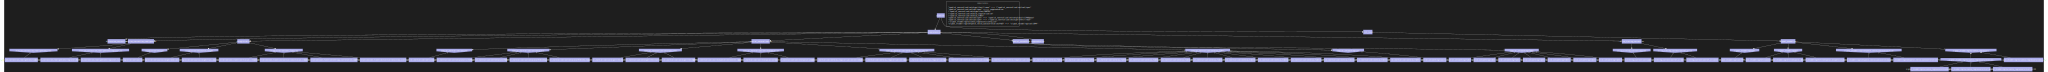

In [265]:
# Load the .dot file
with open('/home/ymerel/fmri-feature-model/model/uvl/full_pipeline.dot', 'r') as file:
    dot_data = file.read()

# Create a Graphviz Source object
src = graphviz.Source(dot_data)

# Render the graph to a file (e.g., PDF, PNG)
src.render('full_pipeline', format='png', cleanup=True)

# Display the graph (if using Jupyter Notebook)
src

# Load dataset
90 features + config hash (id) + correlation from ref + correlation from mean

In [266]:
# Mount group storage
!sshfs -o reconnect,ServerAliveInterval=120,ServerAliveCountMax=3 rennes.g5k:/srv/storage/empenn@storage2.rennes.grid5000.fr/private/ymerel /home/ymerel/storage
# load correlations
correlations = pd.read_csv(corr_path, delimiter=';')
matrix = correlations.pivot(index='source', columns='target', values='correlation').fillna(1.0)
distance_matrix = 1 - matrix

fusermount3: failed to access mountpoint /home/ymerel/storage: Permission denied


In [267]:
# write extended dataset (with mean of correlations, 10 random ref)
# Choose 10 random correlations as refs
def get_extended_dataset():
    unique_values = [value for value in correlations['source'].unique() if value not in ['ref', 'mean']]
    random_refs = random.sample(list(unique_values), 10)
    extended_dataset = pd.read_csv(df_path, delimiter=';')
    for ref in random_refs:
        print(f"Fetching correlations for random ref [{ref}]")
        for index, row in extended_dataset.iterrows():
            id_value = row['id']
            correlation = correlations.loc[
            (correlations['source'] == id_value) &
            (correlations['target'] == ref), 'correlation'].values[0]
            extended_dataset.at[index, f'from_{ref}'] = correlation
    print(f"Calculating mean of correlations for each config")
    for index, row in extended_dataset.iterrows():
            id_value = row['id']
            if id_value == 'ref' or id_value == 'mean':
                continue
            values = correlations.loc[
            (correlations['source'] == id_value) & (correlations['target'] != id_value) & (correlations['target'] != 'ref') & (correlations['target'] != 'mean'), 'correlation'].values
            extended_dataset.at[index, f'mean_corr'] =  sum(values) / len(values)
    # write dataset
    extended_dataset.to_csv(os.path.join(basedir, 'extended_dataset.csv'), index=False, sep=';')

# get_extended_dataset()

cluster
2.0    556
1.0    195
4.0    177
3.0     72
Name: count, dtype: int64


<Figure size 2000x2000 with 0 Axes>

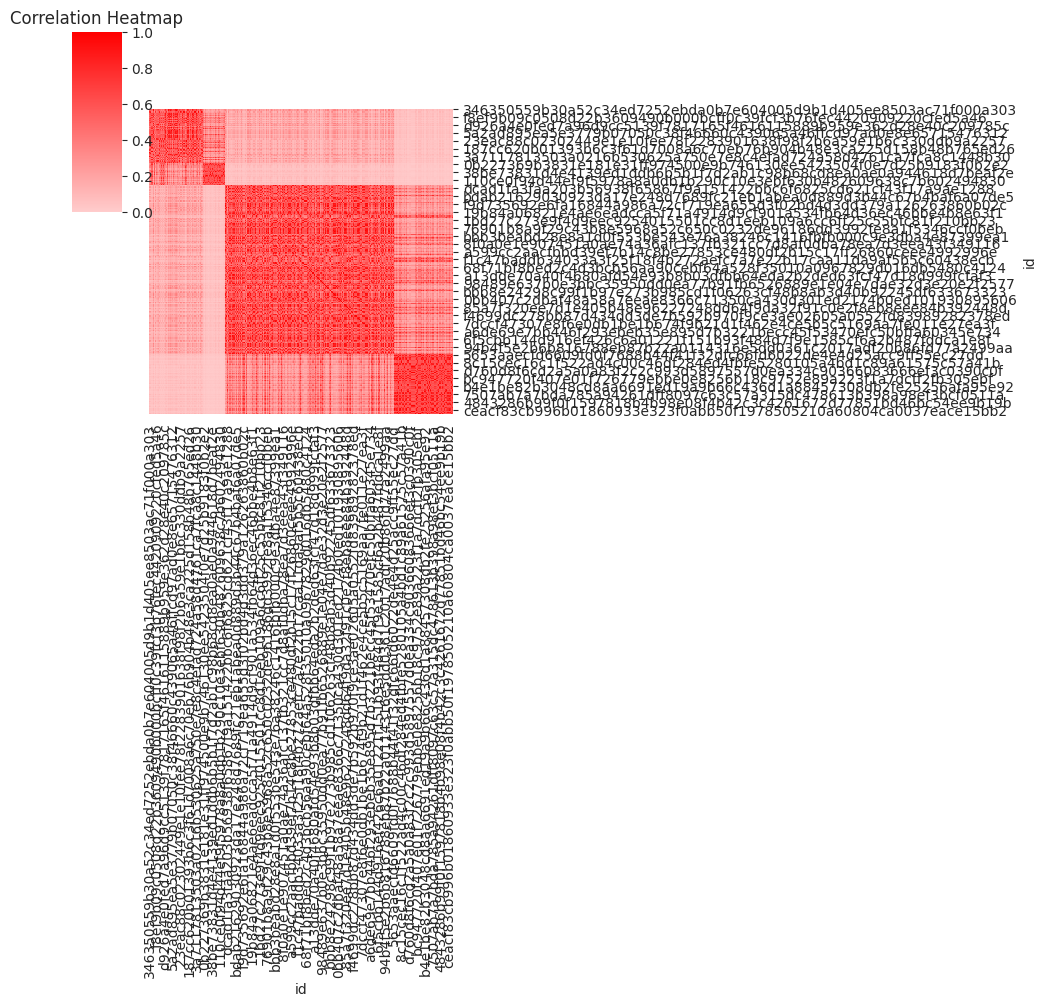

In [268]:
dataset = pd.read_csv(os.path.join(basedir, 'extended_dataset.csv'), delimiter=';')
target_vars = [col for col in dataset.columns if col.startswith('from_')]
target_vars.append('mean_corr')

# hierarchical clustering
nb_clusters = 4
Z = linkage(squareform(distance_matrix), method='complete')
clusters = fcluster(Z, nb_clusters, criterion='maxclust')

mapping = pd.DataFrame({'config': distance_matrix.index, 'cluster': clusters})

for id, row in mapping.iterrows():
    config = row['config']
    cluster = row['cluster']
    dataset.loc[dataset['id'] == config, 'cluster'] = cluster
cluster_counts = dataset['cluster'].value_counts()
print(cluster_counts)
plt.figure(figsize=(20, 20))
cmap = LinearSegmentedColormap.from_list("red_cmap", ["#FFCCCC", "#FF0000"])

# reorder matrix by cluster
sorted_index = dataset.sort_values('cluster', ascending=False)['id']
matrix = matrix.reindex(index=sorted_index, columns=sorted_index)
map = sb.clustermap(matrix, cmap=cmap, vmin=0, vmax=1, row_cluster=False, col_cluster=False, row_linkage=Z, col_linkage=Z)
plt.title('Correlation Heatmap')
plt.show()

# Features repartition
Check features repartition for all configurations vs sample

Retrieved all [27648] configurations from [/home/ymerel/fmri-feature-model/model/uvl/full_pipeline.uvl]


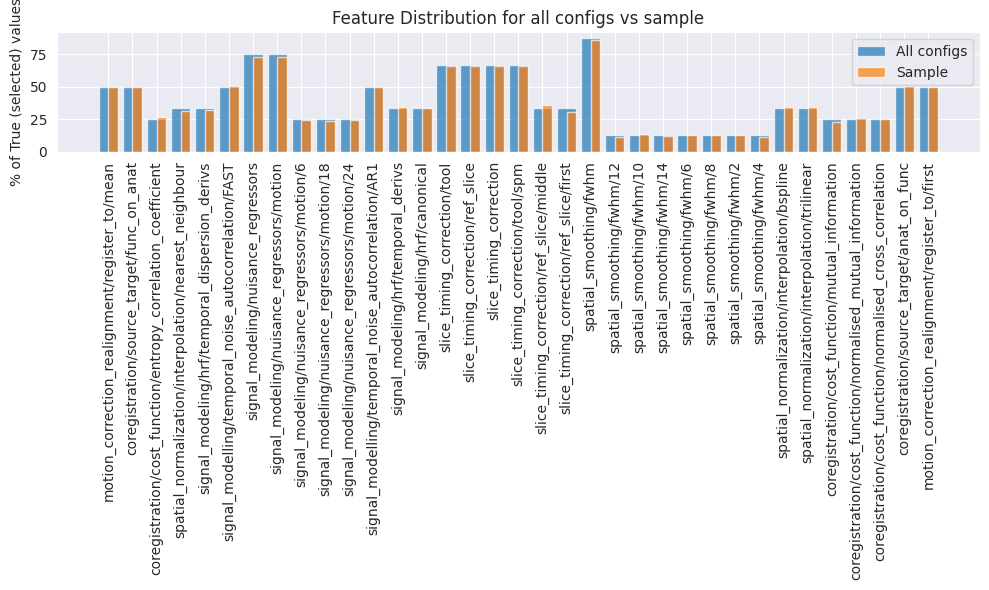

In [269]:
pd.set_option('future.no_silent_downcasting', True)
full = pd.DataFrame(sample_srv.get_all_configs()).fillna(False).astype(bool)
full_rep = full.mean() * 100
full_rep = full_rep[(full_rep > 0) & (full_rep < 100)]
ignored = target_vars.copy()
ignored.append('id')
ignored.append('cluster')
sample_rep = dataset.drop(columns=ignored).mean() * 100
sample_rep = sample_rep[(full_rep > 0) & (sample_rep < 100)]
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the percentages for df1
ax.bar(full_rep.index, full_rep, alpha=0.7, label='All configs')

# Plot the percentages for df2
ax.bar(sample_rep.index, sample_rep, alpha=0.7, label='Sample', align='edge', width=0.4)

# Add labels and title
ax.set_ylabel('% of True (selected) values')
ax.set_title('Feature Distribution for all configs vs sample')
ax.legend()

# Show plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Convert feature with alternative to enum

In [270]:
str_alternatives = {
    "motion_correction_realignment/register_to" : ["first", "mean"],
    "coregistration/source_target" : ["anat_on_func", "func_on_anat"],
    "coregistration/cost_function" : ["mutual_information", "normalised_mutual_information", "entropy_correlation_coefficient", "normalised_cross_correlation"],
    "spatial_normalization/template" : ["Ixi549Space", "MNI305", "MNI152_linear", "MNI152_nonlinear"],
    "spatial_normalization/algorithm" : ["linear", "nonlinear", "DARTEL"],
    "spatial_normalization/interpolation" : ["nearest_neighbour", "trilinear", "bspline"],
    "spatial_normalization/bias_regularisation" : ["extremely_light", "very_light", "light", "medium", "heavy"],
    "slice_timing_correction/ref_slice" : ["first", "middle"],
    "signal_modeling/hrf" : ["canonical", "temporal_derivs", "temporal_dispersion_derivs"],
    "signal_modelling/temporal_noise_autocorrelation" : ["AR1", "FAST"],
}

num_alternatives = {
    "spatial_normalization/bias_fwhm" : [30, 40, 60, 70, 80, 90, 100, 110, 120,130,140,150],
    "spatial_smoothing/fwhm" : [2, 4, 6, 8, 10, 12, 14],
    "signal_modeling/nuisance_regressors/motion" : [6, 18, 24]
}

bias_regs = {
        'extremely_light': 0.00001,
        'very_light': 0.0001,
        'light': 0.001,
        'medium': 0.01,
        'heavy': 0.1
    }

for index, row in dataset.iterrows():
    for feature, values in num_alternatives.items():
        if row[feature] is False:
            dataset.at[index, feature] = 0
            continue
        for val in values:
            alt = f"{feature}/{val}"
            if row[alt] is True:
                dataset.at[index, feature] = val
    for label, value in bias_regs.items():
        if row[f"spatial_normalization/bias_regularisation/{label}"] is True:
            dataset.at[index, "spatial_normalization/bias_regularisation"] = value

for key in num_alternatives:
    for val in num_alternatives[key]:
        dataset = dataset.drop(f"{key}/{val}",  axis=1)
dataset = dataset.convert_dtypes()
# remove always true columns
boolean_columns = dataset.select_dtypes(include='bool').columns
columns_to_drop = [col for col in boolean_columns if dataset[col].all()]
dataset = dataset.drop(columns=columns_to_drop)
dataset.head()

/home/ymerel/tmp/ipykernel_139565/3860823572.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dataset.at[index, feature] = 0
/home/ymerel/tmp/ipykernel_139565/3860823572.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dataset.at[index, feature] = val
/home/ymerel/tmp/ipykernel_139565/3860823572.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dataset.at[index, feature] = 0


,slice_timing_correction/ref_slice/middle,signal_modeling/hrf/temporal_dispersion_derivs,coregistration/cost_function/mutual_information,signal_modeling/nuisance_regressors/comp_cor,signal_modelling/temporal_noise_autocorrelation/FAST,spatial_normalization/algorithm/DARTEL,spatial_normalization/interpolation/bspline,spatial_normalization/bias_regularisation,spatial_normalization/template/MNI152_linear,spatial_normalization/bias_regularisation/extremely_light,...,from_e2981f97fc870a8fc8a66d9a40c3cc8dcb21be746ad83ecbcc320c8fe4298a73,from_bdab21629030923da17e248d7689fc21eb1abea0d889d3b44c67b4baf6a07de5,from_6363ceb4ad5221e2fd865e8ba9181032905c33814f925c2e960adcd5354485e4,from_2566dc31e9fbea6d892a21f56ecb62ff9df850705b65b17754f772d13f060284,from_6b4189bcd2f407a23e0ebc2d14de55529eaab1b0f5a612ba46b79d019b03cc46,from_c475f858fc2881ef01d1d4b705346000d23d56508ee89dcbf18e173daf48de57,from_5b935ba44056218711fe041d9e5000904a788b010f7c12dd70041a2e5cc4e135,from_05a74cdcbd5faa976b866eec5a083de5e3945cc85a8971c44863127732e7026d,mean_corr,cluster
0,False,True,True,False,False,False,False,False,False,False,...,0.585454,0.467426,0.58446,0.640727,0.422977,0.416205,0.281066,0.813123,0.37296,1
1,True,False,False,False,True,False,True,False,False,False,...,0.464436,0.624274,0.162757,0.311513,0.478202,0.59541,0.58497,0.375992,0.448391,2
2,True,True,False,False,False,False,True,False,False,False,...,0.047896,0.054734,0.017863,0.035509,0.080146,0.109115,0.047371,0.073594,0.162453,3
3,False,True,False,False,False,False,False,False,False,False,...,0.357296,0.454988,0.1603,0.258135,0.83256,0.765298,0.533354,0.457524,0.393672,2
4,True,True,False,False,True,False,False,False,False,False,...,0.047896,0.054734,0.017863,0.035509,0.080146,0.109115,0.047371,0.073594,0.162453,3


# Ref correlations repartition

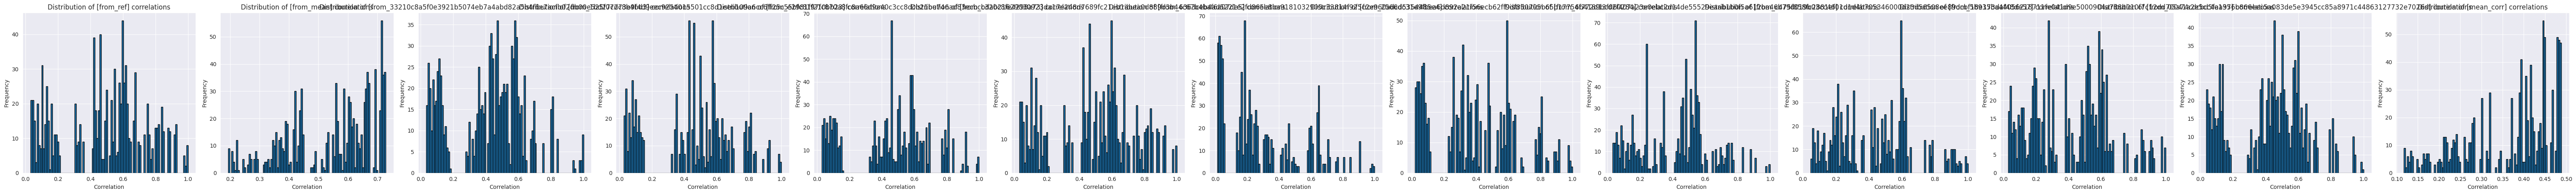

In [271]:
num_plots = len(target_vars)
fig, axes = plt.subplots(ncols=num_plots, figsize=(5 * num_plots, 5))

for i, corr in enumerate(target_vars):
    axes[i].hist(dataset[corr], bins=100, edgecolor='black')
    axes[i].set_title(f'Distribution of [{corr}] correlations')
    axes[i].set_xlabel('Correlation')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


# Stats maps QC
For `from_ref`, `from_mean`, `mean_corr` correlations, display the 3 "worst" and "best" correlated results

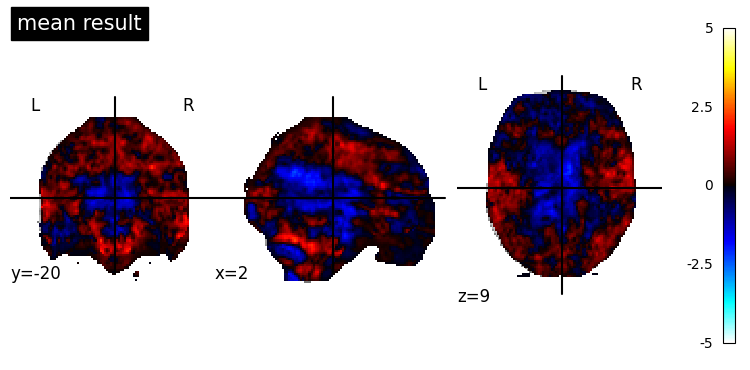

In [272]:
img = nimg.load_img(os.path.join(basedir, 'mean_result.nii'))
plotting.plot_stat_map(img, title='mean result', vmin=-5, vmax=5)
plt.show() 

# todo : mean image for NCC
# todo : mean image per cluster

# for ref in ['from_ref', 'from_mean', 'mean_corr']:
#     print(f"[{ref}] 3 worst correlated maps")
#     for conf_id in dataset.nsmallest(3, ref)['id']:
#         img = nimg.load_img(os.path.join(basedir, conf_id, '_subject_id_01', 'result.nii'))
#         plotting.plot_stat_map(img, title=conf_id, vmin=-5, vmax=5)
#     plt.show() 
#     print(f"[{ref}] 3 best correlated maps")
#     for conf_id in dataset.nlargest(3, ref)['id']:
#         img = nimg.load_img(os.path.join(basedir, conf_id, '_subject_id_01', 'result.nii'))
#         plotting.plot_stat_map(img, title=conf_id, vmin=-5, vmax=5)
#     plt.show() 

In [273]:
filtered_df = dataset[dataset['coregistration/cost_function/normalised_cross_correlation'] == False]
for ref in ['from_ref', 'from_mean', 'mean_corr']:
    mean_ref_true = dataset.loc[dataset['coregistration/cost_function/normalised_cross_correlation'], ref].mean()
    print(f"Mean of [{ref}] if normalised_cross_correlation : [{mean_ref_true}]")
    mean_ref_false = dataset.loc[~dataset['coregistration/cost_function/normalised_cross_correlation'], ref].mean()
    print(f"Mean of [{ref}] if NOT normalised_cross_correlation : [{mean_ref_false}]")

Mean of [from_ref] if normalised_cross_correlation : [0.11262777297978205]
Mean of [from_ref] if NOT normalised_cross_correlation : [0.6064765273717692]
Mean of [from_mean] if normalised_cross_correlation : [0.3415541997686469]
Mean of [from_mean] if NOT normalised_cross_correlation : [0.6090560115006435]
Mean of [mean_corr] if normalised_cross_correlation : [0.21147156215893526]
Mean of [mean_corr] if NOT normalised_cross_correlation : [0.4154731723261163]


# Fit regressor decision tree model for all correlations metrics

In [274]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

results = []
feat_importances = []

X = dataset.drop(columns=ignored)
for metric in target_vars:
    y = dataset[metric]

    test_size=0.3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # Train model
    regressor = tree.DecisionTreeRegressor(max_depth=4)
    regressor.fit(X_train, y_train)
    
    dot_data = tree.export_graphviz(regressor, out_file=None,
                                    feature_names=X_train.columns.values,
                                    filled=True, rounded=True,
                                    special_characters=True,
                                    leaves_parallel=True, proportion=True)
    graph = graphviz.Source(dot_data)  
    graph.render(f"{metric}")
    
    # learning curve
    # Define the range of training sizes
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    # Compute the learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        regressor, X, y, train_sizes=train_sizes, cv=10, scoring='neg_mean_absolute_percentage_error'
    )
     
    features = X.columns
    importances = regressor.feature_importances_
    for i, feat in enumerate(features): 
        feat_importances.append((metric, feat, importances[i]))

    results.append((metric, 
                  mean_absolute_error(y_test, regressor.predict(X_test)),
                  mean_squared_error(y_test, regressor.predict(X_test)), 
                  mean_absolute_percentage_error(y_test, regressor.predict(X_test)),
                    np.mean(train_scores, axis=1),
                    np.std(train_scores, axis=1),
                    np.mean(test_scores, axis=1),
                    np.std(test_scores, axis=1)  
                    )
    )

# Fit classifier decision tree model for clusters

In [275]:
y = dataset['cluster']
test_size=0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)


# Train the Decision Tree Classifier
classifier = tree.DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)

dot_data = tree.export_graphviz(classifier, out_file=None, 
                         feature_names=X_train.columns.values,  
                         filled=True, rounded=True,
                         special_characters=True,
                                    leaves_parallel=True,proportion=True)
graph = graphviz.Source(dot_data)  
graph.render(f"cluster")

# learning curve
# Define the range of training sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    classifier, X, y, train_sizes=train_sizes, cv=10, scoring='neg_mean_absolute_percentage_error'
)
 
features = X.columns
importances = classifier.feature_importances_
for i, feat in enumerate(features): 
    feat_importances.append(('cluster', importances[i]))

results.append(('cluster', 
              mean_absolute_error(y_test, classifier.predict(X_test)),
              mean_squared_error(y_test, classifier.predict(X_test)), 
              mean_absolute_percentage_error(y_test, classifier.predict(X_test)),
                np.mean(train_scores, axis=1),
                np.std(train_scores, axis=1),
                np.mean(test_scores, axis=1),
                np.std(test_scores, axis=1)  
                )
)

In [276]:
results_df = pd.DataFrame(results, columns=['Metric', 'MAE',  'MSE', 'MAPE', 'train_mean', 'train_std', 'test_mean', 'test_std']).sort_values(by='MAPE', ascending=False)
results_df.head(14)

,Metric,MAE,MSE,MAPE,train_mean,train_std,test_mean,test_std
0,from_ref,0.050301,0.005124,11.053934,"[-0.07336563954427783, -0.09699737728164774, -...","[0.0041237998003632835, 0.006130547856670262, ...","[-0.20213967666227486, -0.12051446667336921, -...","[0.06048130852305595, 0.012254354378223016, 0...."
7,from_2566dc31e9fbea6d892a21f56ecb62ff9df850705...,0.037404,0.003789,10.541154,"[-0.06188756523736173, -0.0945994240210654, -0...","[0.0056032509661837916, 0.0034225504057066518,...","[-0.16963766699360183, -0.1374769409765221, -0...","[0.02215692455023584, 0.020751763691749997, 0...."
3,from_1bd27c273e9f4d9eec9254015501cc8d1eeb109a6...,0.050051,0.005071,10.390747,"[-0.06375246737109229, -0.08796909561245406, -...","[0.004983999058049496, 0.002982586080877119, 0...","[-0.18482799061793687, -0.12438134213169798, -...","[0.05073689923143094, 0.010959691567259691, 0...."
4,from_e2981f97fc870a8fc8a66d9a40c3cc8dcb21be746...,0.047053,0.004367,10.363962,"[-0.06244380732885453, -0.08699253306037438, -...","[0.0034627779854351625, 0.0032637751392847105,...","[-0.18171033390386118, -0.12231000679306922, -...","[0.05390987542979131, 0.011671559004892518, 0...."
6,from_6363ceb4ad5221e2fd865e8ba9181032905c33814...,0.028537,0.002307,9.964451,"[-0.06687749081545574, -0.07430132295344553, -...","[0.003322137646277228, 0.004896929127757891, 0...","[-0.14809814723502873, -0.1040668228594948, -0...","[0.02060987105055986, 0.008452097178292903, 0...."
5,from_bdab21629030923da17e248d7689fc21eb1abea0d...,0.044309,0.004098,9.581802,"[-0.07333126918380183, -0.09701945264184964, -...","[0.004088469766004026, 0.00612802906241129, 0....","[-0.20798811149816485, -0.12141776663169282, -...","[0.05723901782294297, 0.011951901381203198, 0...."
11,from_05a74cdcbd5faa976b866eec5a083de5e3945cc85...,0.038636,0.002870,9.528393,"[-0.0628100172618491, -0.07268064984647311, -0...","[0.002315455150470238, 0.0031105892459236634, ...","[-0.1450020619821354, -0.11018524759787227, -0...","[0.026499846704972203, 0.010273712503505965, 0..."
2,from_33210c8a5f0e3921b5074eb7a4abd82a5b4f6e7ac...,0.037367,0.003125,9.433301,"[-0.06333620689602645, -0.07301993458794835, -...","[0.0025721637175698804, 0.003116962971617411, ...","[-0.15192736652952216, -0.1121128127529258, -0...","[0.023481553055788446, 0.012078590074803752, 0..."
10,from_5b935ba44056218711fe041d9e5000904a788b010...,0.038326,0.003171,9.343355,"[-0.04643474060020743, -0.0816620657162332, -0...","[0.012730652305789552, 0.005457834902725878, 0...","[-0.13572521538630686, -0.0994226738050943, -0...","[0.023166206370776175, 0.01533722012367602, 0...."
9,from_c475f858fc2881ef01d1d4b705346000d23d56508...,0.029926,0.001742,8.156581,"[-0.046148345557791036, -0.06617864532043591, ...","[0.004609958543050114, 0.0034355364835267693, ...","[-0.1675568549487234, -0.11166384298205852, -0...","[0.04538523924742351, 0.01444614573009607, 0.0..."


In [277]:
importance_df = pd.DataFrame(feat_importances, columns=['Metric', 'Feature', 'Importance']).sort_values(by='Importance', ascending=False)
importance_df.head(40)

,Metric,Feature,Importance
141,from_1bd27c273e9f4d9eec9254015501cc8d1eeb109a6...,coregistration/cost_function/normalised_cross_...,0.776334
179,from_e2981f97fc870a8fc8a66d9a40c3cc8dcb21be746...,coregistration/cost_function/normalised_cross_...,0.764520
445,from_05a74cdcbd5faa976b866eec5a083de5e3945cc85...,coregistration/cost_function/normalised_cross_...,0.753622
483,mean_corr,coregistration/cost_function/normalised_cross_...,0.730145
217,from_bdab21629030923da17e248d7689fc21eb1abea0d...,coregistration/cost_function/normalised_cross_...,0.725091
103,from_33210c8a5f0e3921b5074eb7a4abd82a5b4f6e7ac...,coregistration/cost_function/normalised_cross_...,0.714063
27,from_ref,coregistration/cost_function/normalised_cross_...,0.713689
65,from_mean,coregistration/cost_function/normalised_cross_...,0.639103
331,from_6b4189bcd2f407a23e0ebc2d14de55529eaab1b0f...,coregistration/cost_function/normalised_cross_...,0.605457
256,from_6363ceb4ad5221e2fd865e8ba9181032905c33814...,spatial_smoothing/fwhm,0.585432


# Mean absolute percentage error per metric

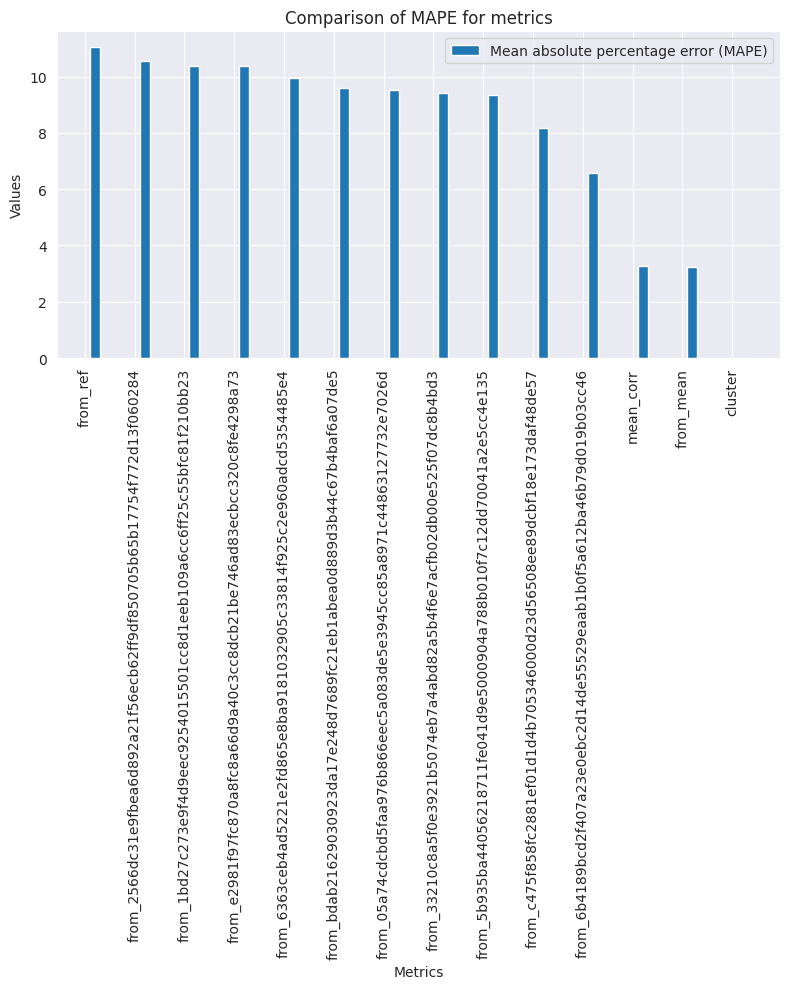

In [278]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 10))
bar_width = 0.2
index = np.arange(len(results_df['Metric']))

# Plot bars for each metric
bar3 = ax.bar(index + 2 * bar_width, results_df['MAPE'], bar_width, label='Mean absolute percentage error (MAPE)')

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of MAPE for metrics')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(results_df['Metric'])
ax.legend()

# Display the plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Learning curves of fitted models

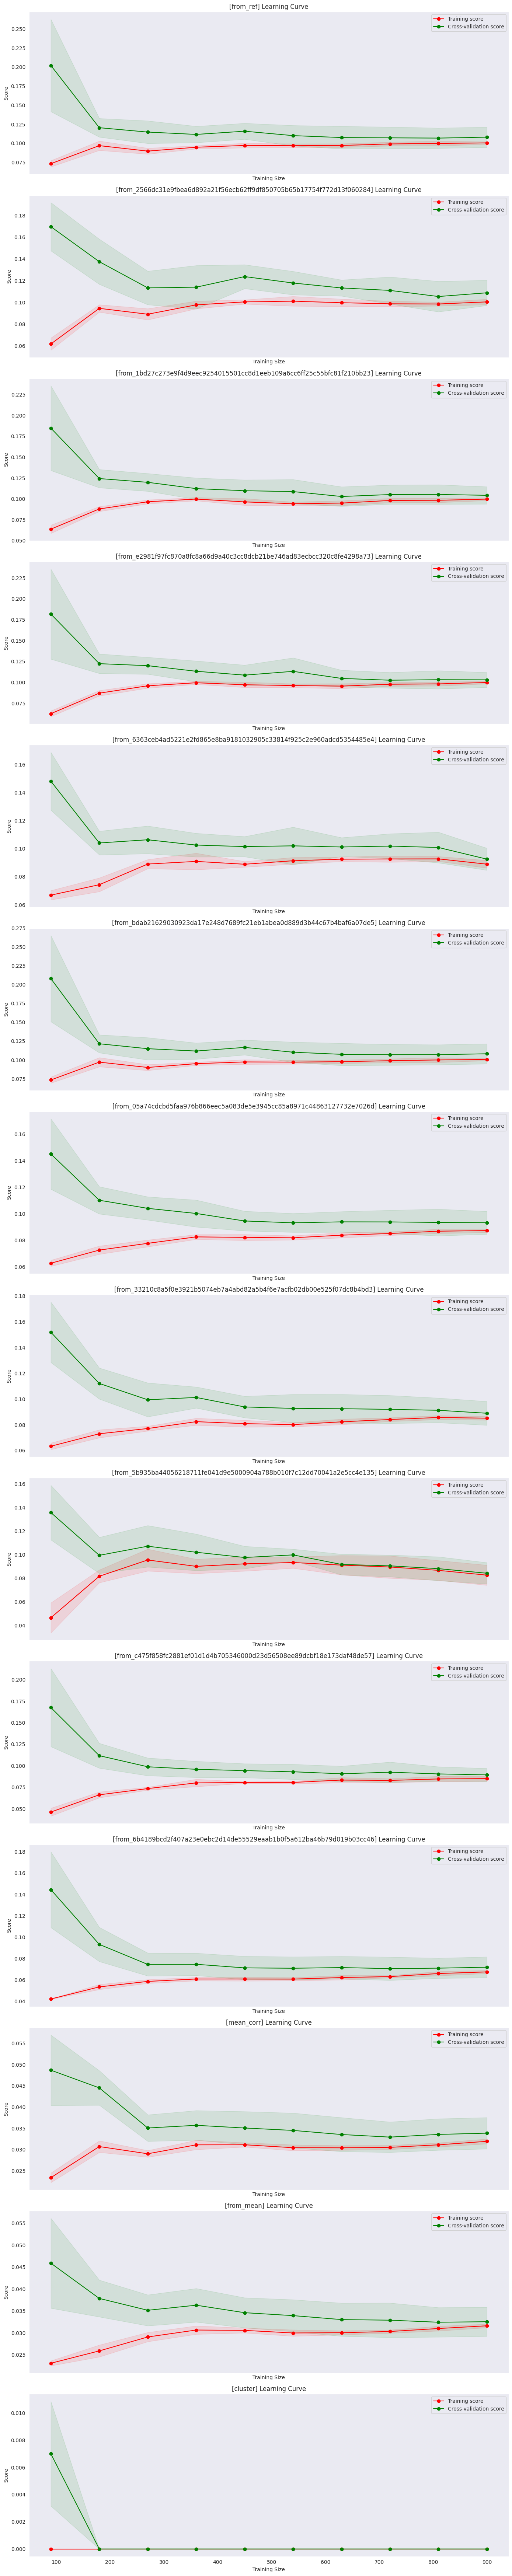

In [279]:
# Plotting
num_metrics = len(results_df)
fig, axes = plt.subplots(nrows=num_metrics, figsize=(num_metrics, num_metrics * 5), sharex=True)

for i, (index, row) in enumerate(results_df.iterrows()):
    ax = axes[i]
    ax.plot(train_sizes, -row['train_mean'], 'o-', color='r', label='Training score')
    ax.plot(train_sizes, -row['test_mean'], 'o-', color='g', label='Cross-validation score')
    ax.fill_between(train_sizes, -row['train_mean'] - row['train_std'], -row['train_mean'] + row['train_std'], alpha=0.1, color='r')
    ax.fill_between(train_sizes, -row['test_mean'] - row['test_std'], -row['test_mean'] + row['test_std'], alpha=0.1, color='g')
    ax.grid()
    ax.set_xlabel('Training Size')
    ax.set_ylabel('Score')
    ax.set_title(f'[{row["Metric"]}] Learning Curve')
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

# Correlations clustermap

In [280]:
correlations = pd.read_csv(corr_path, delimiter=';')
correlations.head()

,source,target,correlation
0,0a3e49ee189809ec52afbdb3c3c5083f090dcb0d218326...,0a3e49ee189809ec52afbdb3c3c5083f090dcb0d218326...,1.0
1,5c20760d37a8aa728efbbec6efc518da72c638cc88cdcd...,27682e60e19461bb32135219bee090029916238dfaf2f0...,1.0
2,3097a7dc41788499cf25575641e12f92017eaec464039b...,3d1d19d1d409196d5fa1185e4aa24f30701dd6cc448a06...,1.0
3,bbb3beabd28e8a1d0f553be543e76a38246c1416fbfb00...,bbb3beabd28e8a1d0f553be543e76a38246c1416fbfb00...,1.0
4,63bea197905677a189c165af71c8fc3933529cfb732832...,3097a7dc41788499cf25575641e12f92017eaec464039b...,1.0


# Computational cost

In [281]:
with open('/home/ymerel/storage/results/auditory/jobs.json', 'r') as file:
        data = json.load(file)

In [282]:
jobs = []
run_hours = 0
post_hours = 0
for id, job in data['jobs'].items():
    if job['owner'] == 'ymerel' and job['state'] == 'Terminated':
        if job['name'] == 'fmri-confs-runner':
            run_hours += (job['stop_time'] - job['start_time']) / 3600
        if job['name'] == 'postprocess-confs':
            post_hours += (job['stop_time'] - job['start_time']) / 3600
        jobs.append(job)
print(f"[pipelines] Total runtime (h) : {run_hours}")
print(f"[pipelines] Runtime per pipelines (min) : {(run_hours / 1000)*60}")
print(f"[postprocessing] Total runtime (h) : {post_hours}")

[pipelines] Total runtime (h) : 49.0663888888889
[pipelines] Runtime per pipelines (min) : 2.943983333333334
[postprocessing] Total runtime (h) : 28.61944444444444
